In [1]:
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Load top node information
nodes = pd.read_csv('annot_tfs.tsv', sep='\t')
nr_nodes = len(nodes['node'])
nodes['node']

0    YIL131C
1    YNL068C
2    YCR065W
3    YDL056W
4    YER111C
5    YOR083W
6    YDR451C
7    YML027W
Name: node, dtype: object

In [3]:
# Load parameters for the top regulation of each node
gamma_vect = np.empty((1,nr_nodes));
beta_vect = np.empty((1,nr_nodes));
alpha_vect = np.empty((1,nr_nodes));
K_vect = np.empty((1,nr_nodes));
n_vect = np.empty((1,nr_nodes));
type_reg_list = [];
reg_nr_vect = np.empty((1,nr_nodes));

# Extract LEM parameters from top regulator for each gene
for i in range(nr_nodes):
    name = nodes['node'][i]
    tsv_data = pd.read_csv("targets_tfs/target_%s_ts0.tsv" % name,sep='\t',nrows = 1,skiprows = [0,1,2,3])
    tsv_np   = tsv_data.to_numpy()[0]
    type_reg_list.append(tsv_np[0][3])
    reg                = tsv_np[0][7:14] # modify the end of this range (8) to reflect number of letters in name of gene in your database)
    gamma_vect[0,i]    = tsv_np[5] # basal expression rate
    beta_vect[0,i]     = tsv_np[6] # degradation rate
    alpha_vect[0,i]    = tsv_np[7] # max transcription rate
    K_vect[0,i]        = tsv_np[8] # threshold of regulator
    n_vect[0,i]        = tsv_np[9] # Hill coefficient
    reg_index = nodes.index[nodes['node'] == reg].tolist()
    for j in reg_index:
        reg_nr_vect[0,i] = int(j)
        
# Correct size of vectors of parameters       
gamma_vect  = gamma_vect[0]
beta_vect   = beta_vect[0]
alpha_vect  = alpha_vect[0]
K_vect      = K_vect[0]
n_vect      = n_vect[0]
reg_nr_vect = reg_nr_vect[0].astype(int)

In [4]:
### Extracting parameters from additional regulator
# For example, target YOR083W has two top regulators with close pld scores.
target_add = 5; # index of target with additional regulation

# Load parameters for this additional regulator
name = nodes['node'][target_add]
tsv_data = pd.read_csv("targets_tfs/target_%s_ts0.tsv" % name,sep='\t',nrows = 1,skiprows = [0,1,2,3,4,5])
tsv_np   = tsv_data.to_numpy()[0]
type_reg_add = tsv_np[0][3]
reg          = tsv_np[0][7:14] # modify the end of this range (8) to reflect number of letters in name of gene in your database)
gamma_add    = tsv_np[5] # basal expression rate
beta_add     = tsv_np[6] # degradation rate
alpha_add    = tsv_np[7] # max transcription rate
K_add        = tsv_np[8] # threshold of regulator
n_add        = tsv_np[9] # Hill coefficient
reg_index = nodes.index[nodes['node'] == reg].tolist()
for j in reg_index:
    reg_nr_add = int(j)

In [5]:
### RHS for ODE with one single regulator for each target
def vectorfield(x, t, nr_nodes,gamma,beta,alpha,K,n,type_reg,reg_nr):
    """
    Defines the differential equations for the system.

    Arguments:
        w :  vector of the state variables for all nodes
        t :  time
        p :  vector of the parameters
    """
    f = [];
    for i in range(nr_nodes):
        if type_reg[i]=='a': # activation
            ind = reg_nr[i]  # index of activator
            rhsa = gamma[i] - beta[i]*x[i] + alpha[i]*(x[ind]**n[i])/(x[ind]**n[i]+K[i]**n[i])
            f.append(rhsa)
        else:
            ind = reg_nr[i]  # index of repressor
            rhsr = gamma[i] - beta[i]*x[i] + alpha[i]*(K[i]**n[i])/(x[ind]**n[i]+K[i]**n[i])
            f.append(rhsr)
                
    return f

In [6]:
### RHS for ODE with additional regulator for a target
def vectorfield_add(x, t, nr_nodes,gamma,beta,alpha,K,n,type_reg,reg_nr,
               target_add,gamma_add,beta_add,alpha_add,K_add,n_add,type_reg_add,reg_nr_add):
    """
    Defines the differential equations for the system.

    Arguments:
        w :  vector of the state variables for all nodes
        t :  time
        p :  vector of the parameters
    """
    f = [];
    for i in range(nr_nodes):
        if type_reg[i]=='a': # activation
            ind = reg_nr[i]  # index of activator
            rhsa = gamma[i] - beta[i]*x[i] + alpha[i]*(x[ind]**n[i])/(x[ind]**n[i]+K[i]**n[i])
            f.append(rhsa)
        else:
            ind = reg_nr[i]  # index of repressor
            rhsr = gamma[i] - beta[i]*x[i] + alpha[i]*(K[i]**n[i])/(x[ind]**n[i]+K[i]**n[i])
            f.append(rhsr)
    
    # Replace the RHS of the ODE for the target with two regulators
    # In this case, both regulators are activators. Modify according to your LEM output!
    j = target_add
    ind1 = reg_nr[j] # index of first activator
    ind2 = reg_nr_add # index of second (additional) activator
    # AND logic
    f[target_add] = gamma[j] - beta[j]*x[j] + \
                    alpha[j]*(x[ind1]**n[j])/(x[ind1]**n[j]+K[j]**n[j]) *\
                    (x[ind2]**n_add)/(x[ind2]**n_add+K_add**n_add) # Multiplication: AND logic
    # Here,we used gamma, beta, alpha from the first activator 
    #(could use from the second by using gamma_add, beta_add, and alpha_add instead)
    
#     # OR logic
#     f[target_add] = gamma[j] - beta[j]*x[j] + \
#                     alpha[j]*(x[ind1]**n[j])/(x[ind1]**n[j]+K[j]**n[j]) + \
#                     alpha_add*(x[ind2]**n_add)/(x[ind2]**n_add+K_add**n_add) # Addition: OR logic
#     # Here,we used gamma, beta from the first activator 
#     #(could use from the second by using gamma_add, beta_add instead)
                
    return f

In [7]:
# Initial conditions
x0 = np.empty((1,nr_nodes));
data_file = "RSEM_TPM_timeseries.tsv"
data = pd.read_csv(data_file, sep='\t')
for i in range(nr_nodes):
    name = nodes['node'][i]
    indx_data = data.index[data[data.columns[0]] == name]
    data_node = data.loc[indx_data]
    x0[0,i]   = data_node['0'].to_numpy()[0]
x0 = x0[0]
x0

array([6.64, 4.09, 5.57, 6.61, 1.25, 3.24, 2.74, 2.02])

In [8]:
# ODE solver parameters
abserr    = 1.0e-8
relerr    = 1.0e-6
stoptime  = 245.0  # Final time
numpoints = 50     # Number of time points

# Create the time samples for the output of the ODE solver.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Call the ODE solver.
xsol = odeint(vectorfield, x0, t, args=(nr_nodes,gamma_vect,beta_vect,alpha_vect,K_vect,n_vect,type_reg_list,reg_nr_vect),
              atol=abserr, rtol=relerr)

xsol_add = odeint(vectorfield_add, x0, t, args=(nr_nodes,gamma_vect,beta_vect,alpha_vect,K_vect,n_vect,type_reg_list,reg_nr_vect,\
                                           target_add,gamma_add,beta_add,alpha_add,K_add,n_add,type_reg_add,reg_nr_add),
              atol=abserr, rtol=relerr)

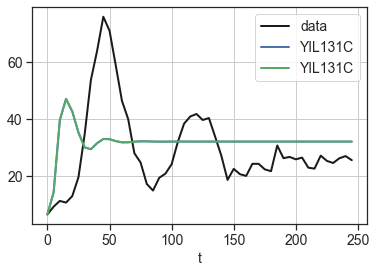

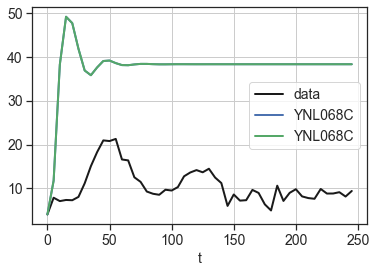

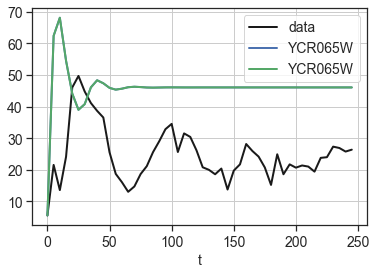

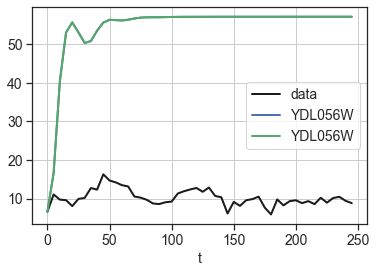

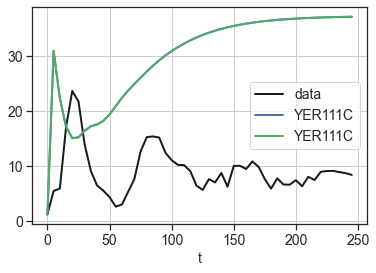

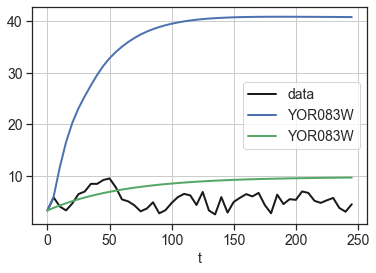

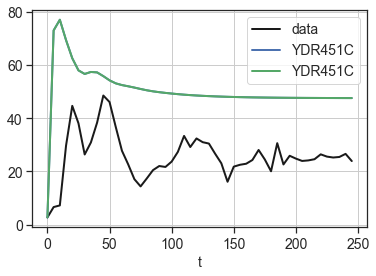

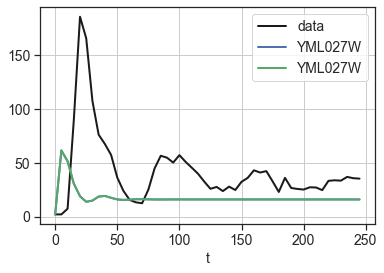

In [9]:
### Plotting
from matplotlib import rc
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn
seaborn.set(style='ticks')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)

for i in range(nr_nodes): #range(0,1):
    name = nodes['node'][i]
    plt.figure()
    
    # plot data
    indx_data = data.index[data[data.columns[0]] == name]
    data_node = data.loc[indx_data]
    data_node.drop(data_node.columns[0],axis=1,inplace=True) # remove first column
    plt.plot(t, data_node.to_numpy()[0], 'k', linewidth=2, label='data')
    
    # plot simulated ODE solutions
    plt.plot(t, xsol[:,i], 'b', linewidth=2, label=name)
    plt.plot(t, xsol_add[:,i], 'g', linewidth=2, label=name)
    
    plt.xlabel('t')
    plt.grid(True)
    plt.legend(fontsize=14)